In [1]:
import csv
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import plotly.graph_objects as go

### **Trajektorien CSVs laden**

In [2]:
def load_csv_to_trajectory(filepath):
    """Lädt die CSV und stellt Trajektorie-Liste wieder her"""
    trajectory = []
    with open(filepath, mode='r', newline='') as file:
        reader = csv.reader(file)
        next(reader)  # Überspringe Kopfzeile

        for row in reader:
            numbers = list(map(float, row))
            trans = numbers[:3]
            rot = numbers[3:]
            trajectory.append((trans, rot))
    return trajectory

In [3]:
hook_num = 19
v = 10
hook_model = 'A'

In [4]:
traj_optim_path = traj_1_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_0.csv'
traj_1_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_1.csv'
traj_2_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_2.csv'
traj_3_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_3.csv'
traj_4_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_4.csv'

In [5]:
trajectory_optim = load_csv_to_trajectory(traj_optim_path)
trajectory_1 = load_csv_to_trajectory(traj_1_path)
trajectory_2 = load_csv_to_trajectory(traj_2_path)
trajectory_3 = load_csv_to_trajectory(traj_3_path)
trajectory_4 = load_csv_to_trajectory(traj_4_path)

### **Euklidsche Distanz**

In [6]:
def interpolate_trajectory(traj, num_points):
    """
    Interpoliert eine Trajektorie auf `num_points` gleichmäßig verteilte Punkte.
    Nur die translatorischen Komponenten werden verwendet (3D Punkte).
    """
    positions = np.array([p[0] for p in traj])  # Nur Positionen
    rotations = np.array([p[1] for p in traj])  # Nur Rotationen
    
    # Abstände zwischen aufeinanderfolgenden Punkten
    deltas_trans = np.linalg.norm(np.diff(positions, axis=0), axis=1)
    deltas_rot = np.linalg.norm(np.diff(rotations, axis=0), axis=1)
    cumulative_dist_trans = np.concatenate([[0], np.cumsum(deltas_trans)])
    cumulative_dist_rot = np.concatenate([[0], np.cumsum(deltas_rot)])
    
    # Gleichmäßig verteilte Distanzen entlang der Trajektorie
    target_distances_trans = np.linspace(0, cumulative_dist_trans[-1], num_points)
    target_distances_rot = np.linspace(0, cumulative_dist_rot[-1], num_points)

    # Interpolation
    interp_positions = []
    interp_rotations = []

    for dist in target_distances_trans:
        idx = np.searchsorted(cumulative_dist_trans, dist) - 1
        idx = np.clip(idx, 0, len(positions) - 2)
        # Lokale lineare Interpolation
        t = (dist - cumulative_dist_trans[idx]) / (cumulative_dist_trans[idx + 1] - cumulative_dist_trans[idx])
        point = (1 - t) * positions[idx] + t * positions[idx + 1]
        interp_positions.append(point)
    
    for rot in target_distances_rot:
        idx = np.searchsorted(cumulative_dist_rot, rot) - 1
        idx = np.clip(idx, 0, len(rotations) - 2)
        # Lokale lineare Interpolation
        t = (rot - cumulative_dist_rot[idx]) / (cumulative_dist_rot[idx + 1] - cumulative_dist_rot[idx])
        point = (1 - t) * rotations[idx] + t * rotations[idx + 1]
        interp_rotations.append(point)
    
    return np.array(interp_positions), np.array(interp_rotations)


def trajectory_distance(traj1, traj2, num_points=10):
    """
    Vergleicht zwei Trajektorien anhand von `num_points` gleichverteilten Punkten.
    Gibt die euklidischen Abstände zurück (Liste) und den Mittelwert.
    """
    interp1_trans, interp1_rot = interpolate_trajectory(traj1, num_points)
    interp2_trans, interp2_rot = interpolate_trajectory(traj2, num_points)

    # Punktweise euklidischer Abstand
    distances = np.linalg.norm(interp1_trans - interp2_trans, axis=1)
    rotations = np.linalg.norm(interp1_rot - interp2_rot, axis=1)
    mean_distance = np.mean(distances)
    mean_rotation = np.mean(rotations)
    max_distance = np.max(distances)
    max_rotation = np.max(rotations)
    return distances, mean_distance, max_distance, rotations, mean_rotation, max_rotation

In [7]:
def plot_trajectory_distances(
    distances=None, 
    mean_distance=None, 
    max_distance=None, 
    rotations=None, 
    mean_rotation=None, 
    max_rotation=None, 
    hook_num=0, 
    trajectory_process=4
):
    """
    Plottet die euklidischen Distanzen und Rotationen entlang der interpolierten Punkte.
    """

    %matplotlib inline
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"Vergleich zwischen optimaler und berechneter Trajektorie - Haken {hook_num}, Trajektorie-Ansatz {trajectory_process} – Distanz", fontsize=14)

    # Plot 1: Euklidische Distanzen
    ax1.set_title(f"Euklidsche Distanz translatorisch")
    ax1.plot(range(1, len(distances) + 1), distances, linestyle='-', marker = '.', label='Euklidische Distanz [mm]')

    if mean_distance is not None:
        ax1.plot(range(1, len(distances) + 1), [mean_distance] * len(distances), linestyle='--', color='red', label='Mittelwert')
    
    if max_distance is not None:
        ax1.plot(range(1, len(distances) + 1), [max_distance] * len(distances), linestyle='--', color='magenta', label=f"Max-Wert - {max_distance:.3f}mm")

    ax1.set_ylabel("Distanz [mm]")
    ax1.grid(True)
    ax1.legend()

    
    # Plot 2: Rotationen
    ax2.set_title("Euklidsche Distanz rotatorisch")
    if rotations is not None:
        ax2.plot(range(1, len(rotations) + 1), rotations, linestyle='-', marker = '.', label='Rotationsabweichung [°]', color='orange')

        if mean_rotation is not None:
            ax2.plot(range(1, len(rotations) + 1), [mean_rotation] * len(rotations), linestyle='--', color='red', label='Mittelwert')
        
        if max_rotation is not None:
            ax2.plot(range(1, len(rotations) + 1), [max_rotation] * len(rotations), linestyle='--', color='magenta', label=f"Max-Wert - {max_rotation:.3f}°")

        ax2.set_ylabel("Rotation [°]")
        ax2.grid(True)
        ax2.legend()
    else:
        ax2.text(0.5, 0.5, "Keine Rotationsdaten verfügbar", ha='center', va='center', transform=ax2.transAxes)
        ax2.axis('off')
    
    ax2.set_xlabel("Punktindex (entlang der Trajektorie)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Platz für Suptitle
    plt.show()

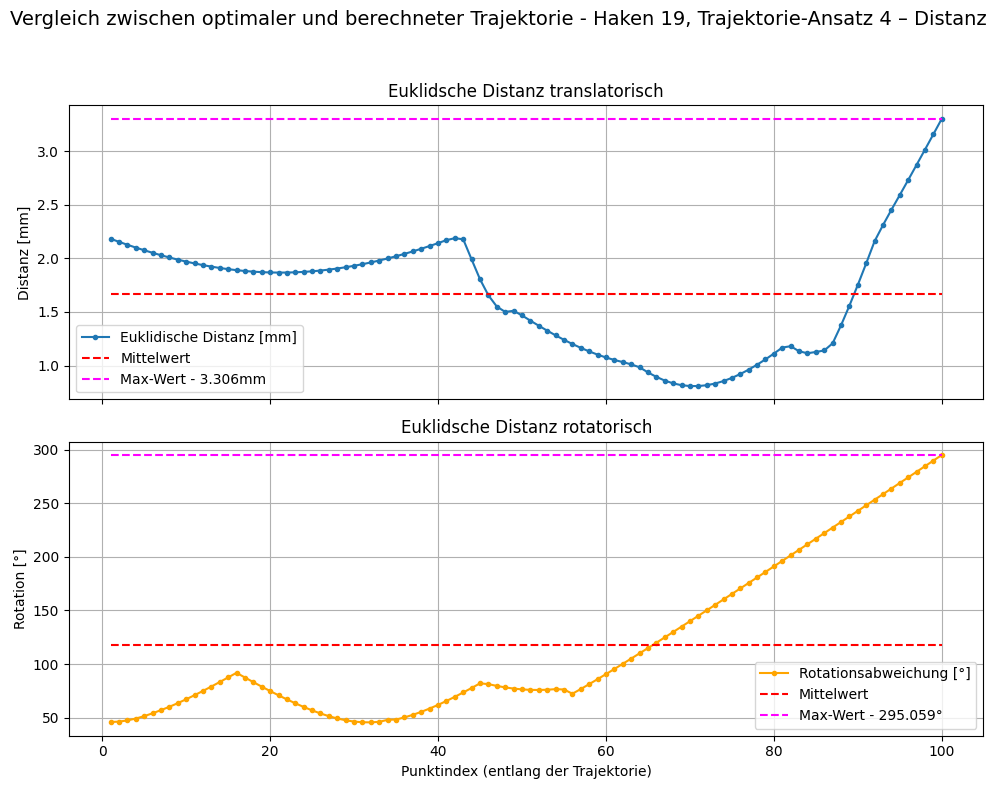

In [8]:
distances, mean_distance, max_distance, rotations, mean_rotation, max_rotation = trajectory_distance(trajectory_1, trajectory_optim, 100)
plot_trajectory_distances(distances, mean_distance, max_distance, rotations, mean_rotation, max_rotation, hook_num = hook_num, trajectory_process = 4)

### **Absolute Distanzen**

In [9]:
def trajectory_difference(traj1, traj2, num_points=10):
    """
    Vergleicht zwei Trajektorien anhand von `num_points` gleichverteilten Punkten.
    Gibt die vorzeichenbehafteten Differenzen für Translation und Rotation zurück.
    Rückgabe:
        diffs_trans: (num_points, 3) - x, y, z
        diffs_rot:   (num_points, 3) - roll, pitch, yaw
    """
    interp1_trans, interp1_rot = interpolate_trajectory(traj1, num_points)
    interp2_trans, interp2_rot = interpolate_trajectory(traj2, num_points)

    # Vorzeichenbehaftete Differenzen
    diffs_trans = interp1_trans - interp2_trans
    diffs_rot = interp1_rot - interp2_rot

    return diffs_trans, diffs_rot

In [10]:
def plot_signed_trajectory_differences(
    diffs_trans, 
    diffs_rot, 
    hook_num=0, 
    trajectory_process=4
):
    """
    Plottet die vorzeichenbehafteten Differenzen (x, y, z, roll, pitch, yaw) 
    entlang der interpolierten Punkte.
    """

    %matplotlib inline
    
    num_points = diffs_trans.shape[0]
    indices = range(1, num_points + 1)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"Vorzeichenbehaftete Differenzen – Haken {hook_num}, Trajektorie-Ansatz {trajectory_process}", fontsize=14)

    # --- Plot 1: Translation (x, y, z) ---
    ax1.set_title("Translation: Abweichung in x, y, z [mm]")
    ax1.plot(indices, diffs_trans[:, 0], label="x [mm]", marker='.', linestyle='-', color='blue')
    ax1.plot(indices, diffs_trans[:, 1], label="y [mm]", marker='.',linestyle='-', color='green')
    ax1.plot(indices, diffs_trans[:, 2], label="z [mm]", marker='.',linestyle='-', color='purple')
    ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    ax1.set_ylabel("Abweichung [mm]")
    ax1.grid(True)
    ax1.legend()

    # --- Plot 2: Rotation (roll, pitch, yaw) ---
    ax2.set_title("Rotation: Abweichung in Roll, Pitch, Yaw [°]")
    ax2.plot(indices, diffs_rot[:, 0], label="roll [°]", marker='.',linestyle='-', color='orange')
    ax2.plot(indices, diffs_rot[:, 1], label="pitch [°]", marker='.',linestyle='-', color='red')
    ax2.plot(indices, diffs_rot[:, 2], label="yaw [°]", marker='.',linestyle='-', color='brown')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    ax2.set_xlabel("Punktindex (entlang der Trajektorie)")
    ax2.set_ylabel("Abweichung [°]")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

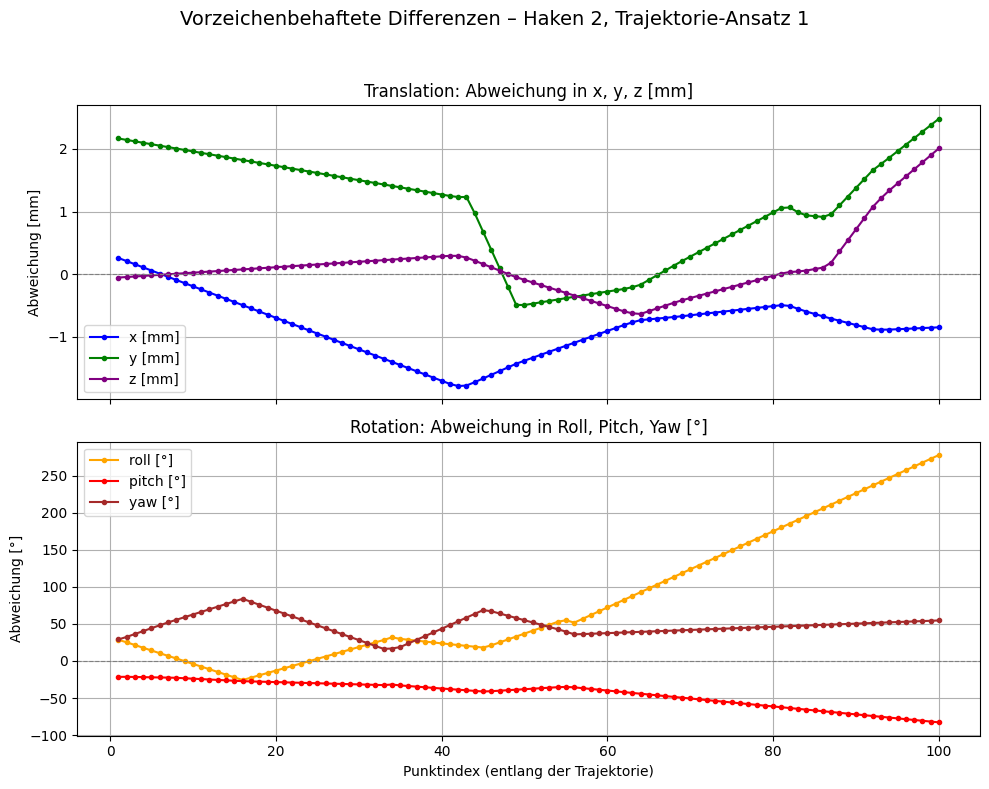

In [11]:
diffs_trans, diffs_rot = trajectory_difference(trajectory_1, trajectory_optim, 100)
plot_signed_trajectory_differences(diffs_trans, diffs_rot, hook_num=2, trajectory_process=1)

### **3D-Darstellung**

In [12]:
def compute_rectangle_corners(trajectory, width=8, height=12):
    """
    Berechnet die Rechteck-Eckpunkte (4 Stück) für jeden Trajektorienpunkt.

    :param trajectory: Liste von ([x, y, z], [roll, pitch, yaw]) Einträgen
    :param width: Breite des Rechtecks (in X-Richtung)
    :param height: Höhe des Rechtecks (in Y-Richtung)
    :return: Liste von Rechtecken, jedes als Liste von 4 Eckpunkten (jeweils [x, y, z])
    """
    rectangles = []

    # Rechteck im lokalen TCP-Koordinatensystem (XY-Ebene, Zentrum im Ursprung)
    half_w = width / 2
    half_h = height / 2
    local_corners = np.array([
        [-half_w, 0, -half_h],
        [ half_w, 0, -half_h],
        [ half_w, 0, half_h],
        [-half_w, 0, half_h]
    ])

    for trans, rpy in trajectory:
        # RPY in Radiant, falls nicht schon so
        rot = R.from_euler('xyz', rpy, degrees=True)
        rotated_corners = rot.apply(local_corners)
        translated_corners = rotated_corners + np.array(trans)
        rectangles.append(translated_corners.tolist())
    return rectangles

In [13]:
rectangles_optim = compute_rectangle_corners(trajectory_optim)
rectangles_1 = compute_rectangle_corners(trajectory_1)
rectangles_2 = compute_rectangle_corners(trajectory_2)
rectangles_3 = compute_rectangle_corners(trajectory_3)
rectangles_4 = compute_rectangle_corners(trajectory_4)

In [14]:
def visualize_rectangles(rectangles, figsize=(8, 8), connect_points=None, 
                         secondary_rectangles=None, secondary_legend_title=None,
                         hook_num = 0, trajectory_process = 1):
    """
    Visualisiert Rechtecke + Trajektorie im 3D-Raum mit Legende und Bezeichnungen der Trajektorienpunkte.
    
    Zusätzlich kann ein zweiter Satz Rechtecke (grau & transparent) dargestellt werden – inkl. Mittelpunktslinie.

    :param rectangles: Liste von Rechtecken (jeweils 4 Punkte [x, y, z])
    :param figsize: Größe der Plotfläche (Breite, Höhe)
    :param connect_points: Optionales Tupel mit zwei Punkten [x, y, z], die verbunden werden sollen
    :param secondary_rectangles: Optionaler zweiter Satz Rechtecke (werden grau dargestellt)
    :param secondary_legend_title: Optionaler Legenden-Eintrag für die grauen Rechtecke
    """
    %matplotlib qt

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f"Einfädelung Trajektorie Spitze -> Senke (TCP in WORLD-Frame)", fontsize=14, y=0.98)

    centers = []
    cmap = cm.get_cmap('tab20')
    legend_handles = []

    # Berechnete Trajektorie (farbig)
    for i, rect in enumerate(rectangles):
        color = cmap(i / len(rectangles))
        poly = Poly3DCollection([rect], facecolors=color, alpha=0.2, edgecolors=color)
        ax.add_collection3d(poly)

        if i == 0:
            label = 'Pre-Position'
        elif i == 1:
            label = 'Spitze'
        elif i == len(rectangles) - 1:
            label = 'Loslassen'
        else:
            label = str(i + 1)

        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label,
                                         markersize=10, markerfacecolor=color))

        center = np.mean(np.array(rect), axis=0)
        centers.append(center)
        ax.scatter(*center, color='red', s=30)
        ax.text(center[0]-5, center[1]-5, center[2], f"P{i}", color=color, alpha = 0.8, fontsize=12)

    # Linie durch die berechneten Mittelpunkte
    centers = np.array(centers)
    ax.plot(centers[:, 0], centers[:, 1], centers[:, 2], color='black', linewidth=2)

    # Beschriftung Hauptlinie
    if len(centers) > 0:
        ax.text(*centers[0], 'Pre-Position', color='black', fontsize=10)
    if len(centers) > 2:
        ax.text(*centers[-1], 'Loslassen', color='black', fontsize=10)

    # Optimal-Trajektorie (grün)
    if secondary_rectangles is not None:
        secondary_centers = []
        for rect in secondary_rectangles:
            poly = Poly3DCollection([rect], facecolors='green', alpha=0.1, edgecolors='green')
            ax.add_collection3d(poly)

            center = np.mean(np.array(rect), axis=0)
            secondary_centers.append(center)
            ax.scatter(*center, color='green', s=20)

        # Linie durch grüne Mittelpunkte
        secondary_centers = np.array(secondary_centers)
        ax.plot(secondary_centers[:, 0], secondary_centers[:, 1], secondary_centers[:, 2],
                color='green', linewidth=1, linestyle='-')

        # Legendenhandle für Optimal-Trajektorie
        if secondary_legend_title:
            legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=secondary_legend_title,
                                             markersize=10, markerfacecolor='green'))

    # Einzeichnen von Spitze und Senke inkl. graue Verbindungslinie
    if connect_points is not None and len(connect_points) == 2:
        p1, p2 = np.array(connect_points[0]), np.array(connect_points[1])
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]],
                color='gray', linestyle='dashed', linewidth=2)
        ax.scatter(*p1, 'o', color='magenta', linewidth=6)
        ax.scatter(*p2, 'o', color='magenta', linewidth=6)
        ax.text(*p1, 'Spitze', color='magenta', fontsize=12, ha='center')
        ax.text(*p2, 'Senke', color='magenta', fontsize=12, ha='center')

    # Achseneinstellungen
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"Haken {hook_num}, Trajektorien-Ansatz {trajectory_process}", fontsize = 10)

    all_points = rectangles + (secondary_rectangles if secondary_rectangles else [])
    all_points = np.vstack(all_points)
    mid = np.mean(all_points, axis=0)
    max_range = np.ptp(all_points, axis=0).max() / 2
    for i, axis in enumerate([ax.set_xlim, ax.set_ylim, ax.set_zlim]):
        axis(mid[i] - max_range, mid[i] + max_range)

    ax.set_box_aspect([1, 1, 1])
    ax.legend(handles=legend_handles, title="Trajektorien-Punkte", loc='upper left')
    plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
    plt.show()

In [15]:
visualize_rectangles(rectangles = rectangles_1,
                     secondary_rectangles = rectangles_optim,
                     secondary_legend_title = 'optimale Trajektorie',
                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
                     hook_num = hook_num,
                     trajectory_process = 1)

visualize_rectangles(rectangles = rectangles_2,
                     secondary_rectangles = rectangles_optim,
                     secondary_legend_title = 'optimale Trajektorie',
                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
                     hook_num = hook_num,
                     trajectory_process = 2)

visualize_rectangles(rectangles = rectangles_3,
                     secondary_rectangles = rectangles_optim,
                     secondary_legend_title = 'optimale Trajektorie',
                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
                     hook_num = hook_num,
                     trajectory_process = 3)

visualize_rectangles(rectangles = rectangles_4,
                     secondary_rectangles = rectangles_optim,
                     secondary_legend_title = 'optimale Trajektorie',
                     connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
                     hook_num = hook_num,
                     trajectory_process = 4)

/tmp/ipykernel_8261/3888305038.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


In [28]:
def visualize_rectangles_html(rectangles, connect_points=None, 
                              secondary_rectangles=None, secondary_legend_title=None,
                              hook_num=0, trajectory_process=1, html_filename="/home/mo/Thesis/Evaluation/Trajektorientests/CSV/plot_interaktiv.html"):
    """
    Visualisiert Rechtecke und Trajektorien im 3D-Raum als interaktive HTML-Datei.
    
    :param rectangles: Liste von Rechtecken (jeweils 4 Punkte [x, y, z])
    :param figsize: Größe der Plotfläche (Breite, Höhe)
    :param connect_points: Optionales Tupel mit zwei Punkten [x, y, z], die verbunden werden sollen
    :param secondary_rectangles: Optionaler zweiter Satz Rechtecke (werden grau dargestellt)
    :param secondary_legend_title: Optionaler Legenden-Eintrag für die grauen Rechtecke
    :param html_filename: Der Name der HTML-Datei, die erstellt wird
    """
    fig = go.Figure()

    # Berechnete Trajektorie (farbig)
    cmap = plt.cm.get_cmap('tab20')
    centers = []

    for i, rect in enumerate(rectangles):
        # Verwende rgba-String für die Farbe (anstatt des RGBA-Tupels)
        color = f"rgba({int(cmap(i / len(rectangles))[0] * 255)}, " \
                f"{int(cmap(i / len(rectangles))[1] * 255)}, " \
                f"{int(cmap(i / len(rectangles))[2] * 255)}, 0.8)"
        x, y, z = zip(*rect)
        fig.add_trace(go.Mesh3d(x=x, y=y, z=z, color=color, opacity=0.8, 
                               name=f'P{i+1}'))

        center = np.mean(np.array(rect), axis=0)
        centers.append(center)
        
        # Text für "P0", "P1", etc.
        if i == 0:
            text_label = ''
            # text_label = 'Pre-Position'
        elif i == 1:
            text_label = ''
            # text_label = 'Spitze'
        elif i == len(rectangles) - 1:
            text_label = ''
            # text_label = 'Loslassen'
        else:
            text_label = f'P{i}'  # Standardtext für den Punkt
        
        # Füge den Text an den Punkten hinzu (mit entsprechender Position)
        fig.add_trace(go.Scatter3d(x=[center[0]], y=[center[1]], z=[center[2]], 
                                   mode='markers+text', marker=dict(size=3, color='red'),
                                   text=text_label, textposition="top center", textfont=dict(size=12), showlegend=False))

        # Hinzufügen der Umrandung der Rechtecke mit einer Linie
        for j in range(4):
            x0, y0, z0 = rect[j]
            x1, y1, z1 = rect[(j + 1) % 4]  # Nächster Punkt im Rechteck
            fig.add_trace(go.Scatter3d(x=[x0, x1], y=[y0, y1], z=[z0, z1], 
                                       mode='lines', 
                                       line=dict(color=color, width=4),  # Keine opacity hier
                                       showlegend=False))

    # Linie durch die berechneten Mittelpunkte
    centers = np.array(centers)
    fig.add_trace(go.Scatter3d(x=centers[:, 0], y=centers[:, 1], z=centers[:, 2],
                               mode='lines', line=dict(color='black', width=2), name='Berechnete Hakenlinie'))

    # Beschriftung der ersten und letzten Punkte
    if len(centers) > 0:
        fig.add_trace(go.Scatter3d(x=[centers[0, 0]], y=[centers[0, 1]], z=[centers[0, 2]],
                                   mode='text', text=['Pre-Position'], textposition="top center", textfont=dict(size=10), showlegend=False))
    if len(centers) > 2:
        fig.add_trace(go.Scatter3d(x=[centers[-1, 0]], y=[centers[-1, 1]], z=[centers[-1, 2]],
                                   mode='text', text=['Loslassen'], textposition="top center", textfont=dict(size=10), showlegend=False))

    # Optimal-Trajektorie (grün) – Zweite Rechtecke
    if secondary_rectangles:
        for rect in secondary_rectangles:
            x, y, z = zip(*rect)
            fig.add_trace(go.Mesh3d(x=x, y=y, z=z, color='rgba(0,255,0,0.2)', opacity=0.8, 
                                   name=secondary_legend_title or 'Optimale Trajektorie'))
        
            # Hinzufügen der Umrandung der Rechtecke mit einer Linie
            for j in range(4):
                x0, y0, z0 = rect[j]
                x1, y1, z1 = rect[(j + 1) % 4]  # Nächster Punkt im Rechteck
                fig.add_trace(go.Scatter3d(x=[x0, x1], y=[y0, y1], z=[z0, z1], 
                                           mode='lines', 
                                           line=dict(color='rgba(0,255,0,0.2)', width=3),  # Keine opacity hier
                                           showlegend=False))
            
            # Hinzufügen eines roten Punktes in der Mitte des Rechtecks
            center = np.mean(np.array(rect), axis=0)
            fig.add_trace(go.Scatter3d(x=[center[0]], y=[center[1]], z=[center[2]], 
                                       mode='markers', marker=dict(size=4, color='green'), 
                                       name=f'Mitte P{i+1}', showlegend=False))
        
        # Mittelpunkte der sekundären Rechtecke sammeln
        secondary_centers = [np.mean(np.array(rect), axis=0) for rect in secondary_rectangles]
        secondary_centers = np.array(secondary_centers)

        # Linie durch die Mittelpunkte zeichnen
        fig.add_trace(go.Scatter3d(
            x=secondary_centers[:, 0], y=secondary_centers[:, 1], z=secondary_centers[:, 2],
            mode='lines',
            line=dict(color='green', width=2),
            name='Optimale Hakenlinie'
        ))
    
    # Einzeichnen von Spitze und Senke inkl. graue Verbindungslinie
    if connect_points:
        p1, p2 = np.array(connect_points[0]), np.array(connect_points[1])
        fig.add_trace(go.Scatter3d(x=[p1[0], p2[0]], y=[p1[1], p2[1]], z=[p1[2], p2[2]], 
                                   mode='lines', line=dict(color='gray', dash='dash'), name='Direkte Gerade Spitze -> Senke'))
        fig.add_trace(go.Scatter3d(x=[p1[0]], y=[p1[1]], z=[p1[2]], mode='markers', 
                                   marker=dict(size=8, color='magenta'), name='Spitze'))
        fig.add_trace(go.Scatter3d(x=[p2[0]], y=[p2[1]], z=[p2[2]], mode='markers', 
                                   marker=dict(size=8, color='magenta'), name='Senke'))
        
        # Hinzufügen von Text "Spitze" und "Senke"
        fig.add_trace(go.Scatter3d(x=[p1[0]], y=[p1[1]], z=[p1[2]], mode='text', 
                                   text=['Spitze'], textposition="top center", textfont=dict(size=10), showlegend=False))
        fig.add_trace(go.Scatter3d(x=[p2[0]], y=[p2[1]], z=[p2[2]], mode='text', 
                                   text=['Senke'], textposition="top center", textfont=dict(size=10), showlegend=False))

    # Achsen und Layout
    fig.update_layout(scene=dict(
                        xaxis_title='X',
                        yaxis_title='Y',
                        zaxis_title='Z',
                        aspectmode='cube'),
                      title=f'Haken {hook_num}, Trajektorien-Ansatz {trajectory_process}',
                      legend=dict(title="Legende"))
    
    # HTML exportieren
    fig.write_html(html_filename)
    print(f"HTML-Datei '{html_filename}' erfolgreich erstellt!")
    fig.show()

In [29]:
visualize_rectangles_html(
    rectangles = rectangles_1,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 1,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj1.html'
    )

visualize_rectangles_html(
    rectangles = rectangles_2,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 2,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj2.html'
    )

visualize_rectangles_html(
    rectangles = rectangles_3,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 3,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj3.html'
    )

visualize_rectangles_html(
    rectangles = rectangles_4,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 4,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj4.html'
    )

HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj1.html' erfolgreich erstellt!


/tmp/ipykernel_8261/442480858.py:17: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj2.html' erfolgreich erstellt!


HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj3.html' erfolgreich erstellt!


HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj4.html' erfolgreich erstellt!
